In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [3]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [4]:
qqq_df = pd.read_csv('/content/drive/MyDrive/momentum-strategies/technical_indicator/QQQ_daily.csv')

In [5]:
qqq_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-18,117.900002,118.099998,117.209999,117.320000,112.961899,16428700
1,2016-11-21,117.610001,118.650002,117.570000,118.540001,114.136597,20268500
2,2016-11-22,119.010002,119.190002,118.610001,118.900002,114.483200,18850600
3,2016-11-23,118.510002,118.639999,117.900002,118.419998,114.021042,22926000
4,2016-11-25,118.559998,118.849998,118.419998,118.800003,114.386917,7162800
...,...,...,...,...,...,...,...
1253,2021-11-11,392.570007,392.750000,390.239990,390.589996,390.589996,32243000
1254,2021-11-12,391.769989,395.250000,390.130005,394.700012,394.700012,34669800
1255,2021-11-15,395.910004,396.239990,392.100006,394.609985,394.609985,33716900
1256,2021-11-16,393.859985,397.929993,393.660004,397.420013,397.420013,27872900


In [9]:
def get_bollinger_bands(prices, length, width):
  # type(prices) == pandas.Series
  sma = prices.rolling(length).mean()
  stddev = prices.rolling(length).std(ddof=0)
  return sma, sma + width * stddev, sma - width * stddev

In [10]:
def benchmark_bnh(benchmark_df, initial_cash, start):
  closes = np.full(start, initial_cash)
  initial_shares = initial_cash // benchmark_df['Open'][start]
  initial_cash -= initial_shares * benchmark_df['Open'][start]
  benchmark_closes = benchmark_df['Close']
  return np.concatenate((closes, benchmark_df['Close'][start:] * initial_shares + initial_cash), axis=0)

In [14]:
def bollinger_bands_momentum(benchmark_df, config):
  df = benchmark_df.copy()
  df.drop(['High', 'Adj Close', 'Volume'], axis=1, inplace=True)
  df.rename(columns={'Date':'date', 'Close':'closes', 'Open':'opens', 'Low':'lows'}, inplace=True)
  df['sma'], df['bb_upper'], df['bb_lower'] = get_bollinger_bands(df['closes'], config['length'], config['width'])
  shares, cash, signals = [np.zeros(len(df['closes'])) for _ in range(3)]
  cash[0] = config['initial_cash']
  for i in range(1, len(df['closes'])):
    cash[i] = cash[i - 1]
    shares[i] = shares[i - 1]
    if signals[i] > 0:
      shares_delta = cash[i] // df['opens'][i]
      shares[i] = shares[i - 1] + shares_delta
      cash[i] = cash[i - 1] - shares_delta * df['opens'][i]
    elif signals[i] < 0:
      if shares[i] > 0:
        cash[i] = cash[i - 1] + shares[i] * df['opens'][i]
        shares[i] = 0
    try:
      if df['closes'][i] > df['bb_upper'][i]:
        signals[i + 1] = 1
      elif df['closes'][i] < df['bb_lower'][i]:
        signals[i + 1] = -1
    except IndexError:
        pass
  df['shares'] = shares
  df['cash'] = cash
  df['signals'] = signals
  df['portfolio_closes'] = cash + shares * df['closes']
  df.to_csv(f'/content/drive/MyDrive/momentum-strategies/technical_indicator/{current_date}_BB_momentum_{config["length"]}_{config["width"]}.csv')
  return df['portfolio_closes']

In [20]:
def backtest(benchmark_df, initial_cash):
  returns_df = pd.DataFrame({'date': benchmark_df['Date']})
  returns_df['benchmark'] = benchmark_bnh(benchmark_df, initial_cash, 20)
  returns_df['bb20_2'] = bollinger_bands_momentum(benchmark_df, {'length':20, 'width':2, 'initial_cash':initial_cash})
  returns_df['bb20_1'] = bollinger_bands_momentum(benchmark_df, {'length':20, 'width':1, 'initial_cash':initial_cash})
  return returns_df

In [18]:
returns_df = backtest(qqq_df, 10000)

In [26]:
def chart(returns_df):
  chart = returns_df.plot(x='date', grid=True, figsize=(40,25), xticks=np.arange(0, len(returns_df['date']), 20), yticks=np.arange(returns_df['benchmark'][0] * 0.9, returns_df['benchmark'][0] * 3.5, returns_df['benchmark'][0] * 0.1), title="BB momentum strategy")
  chart.tick_params(axis='x', rotation=90)
  return chart

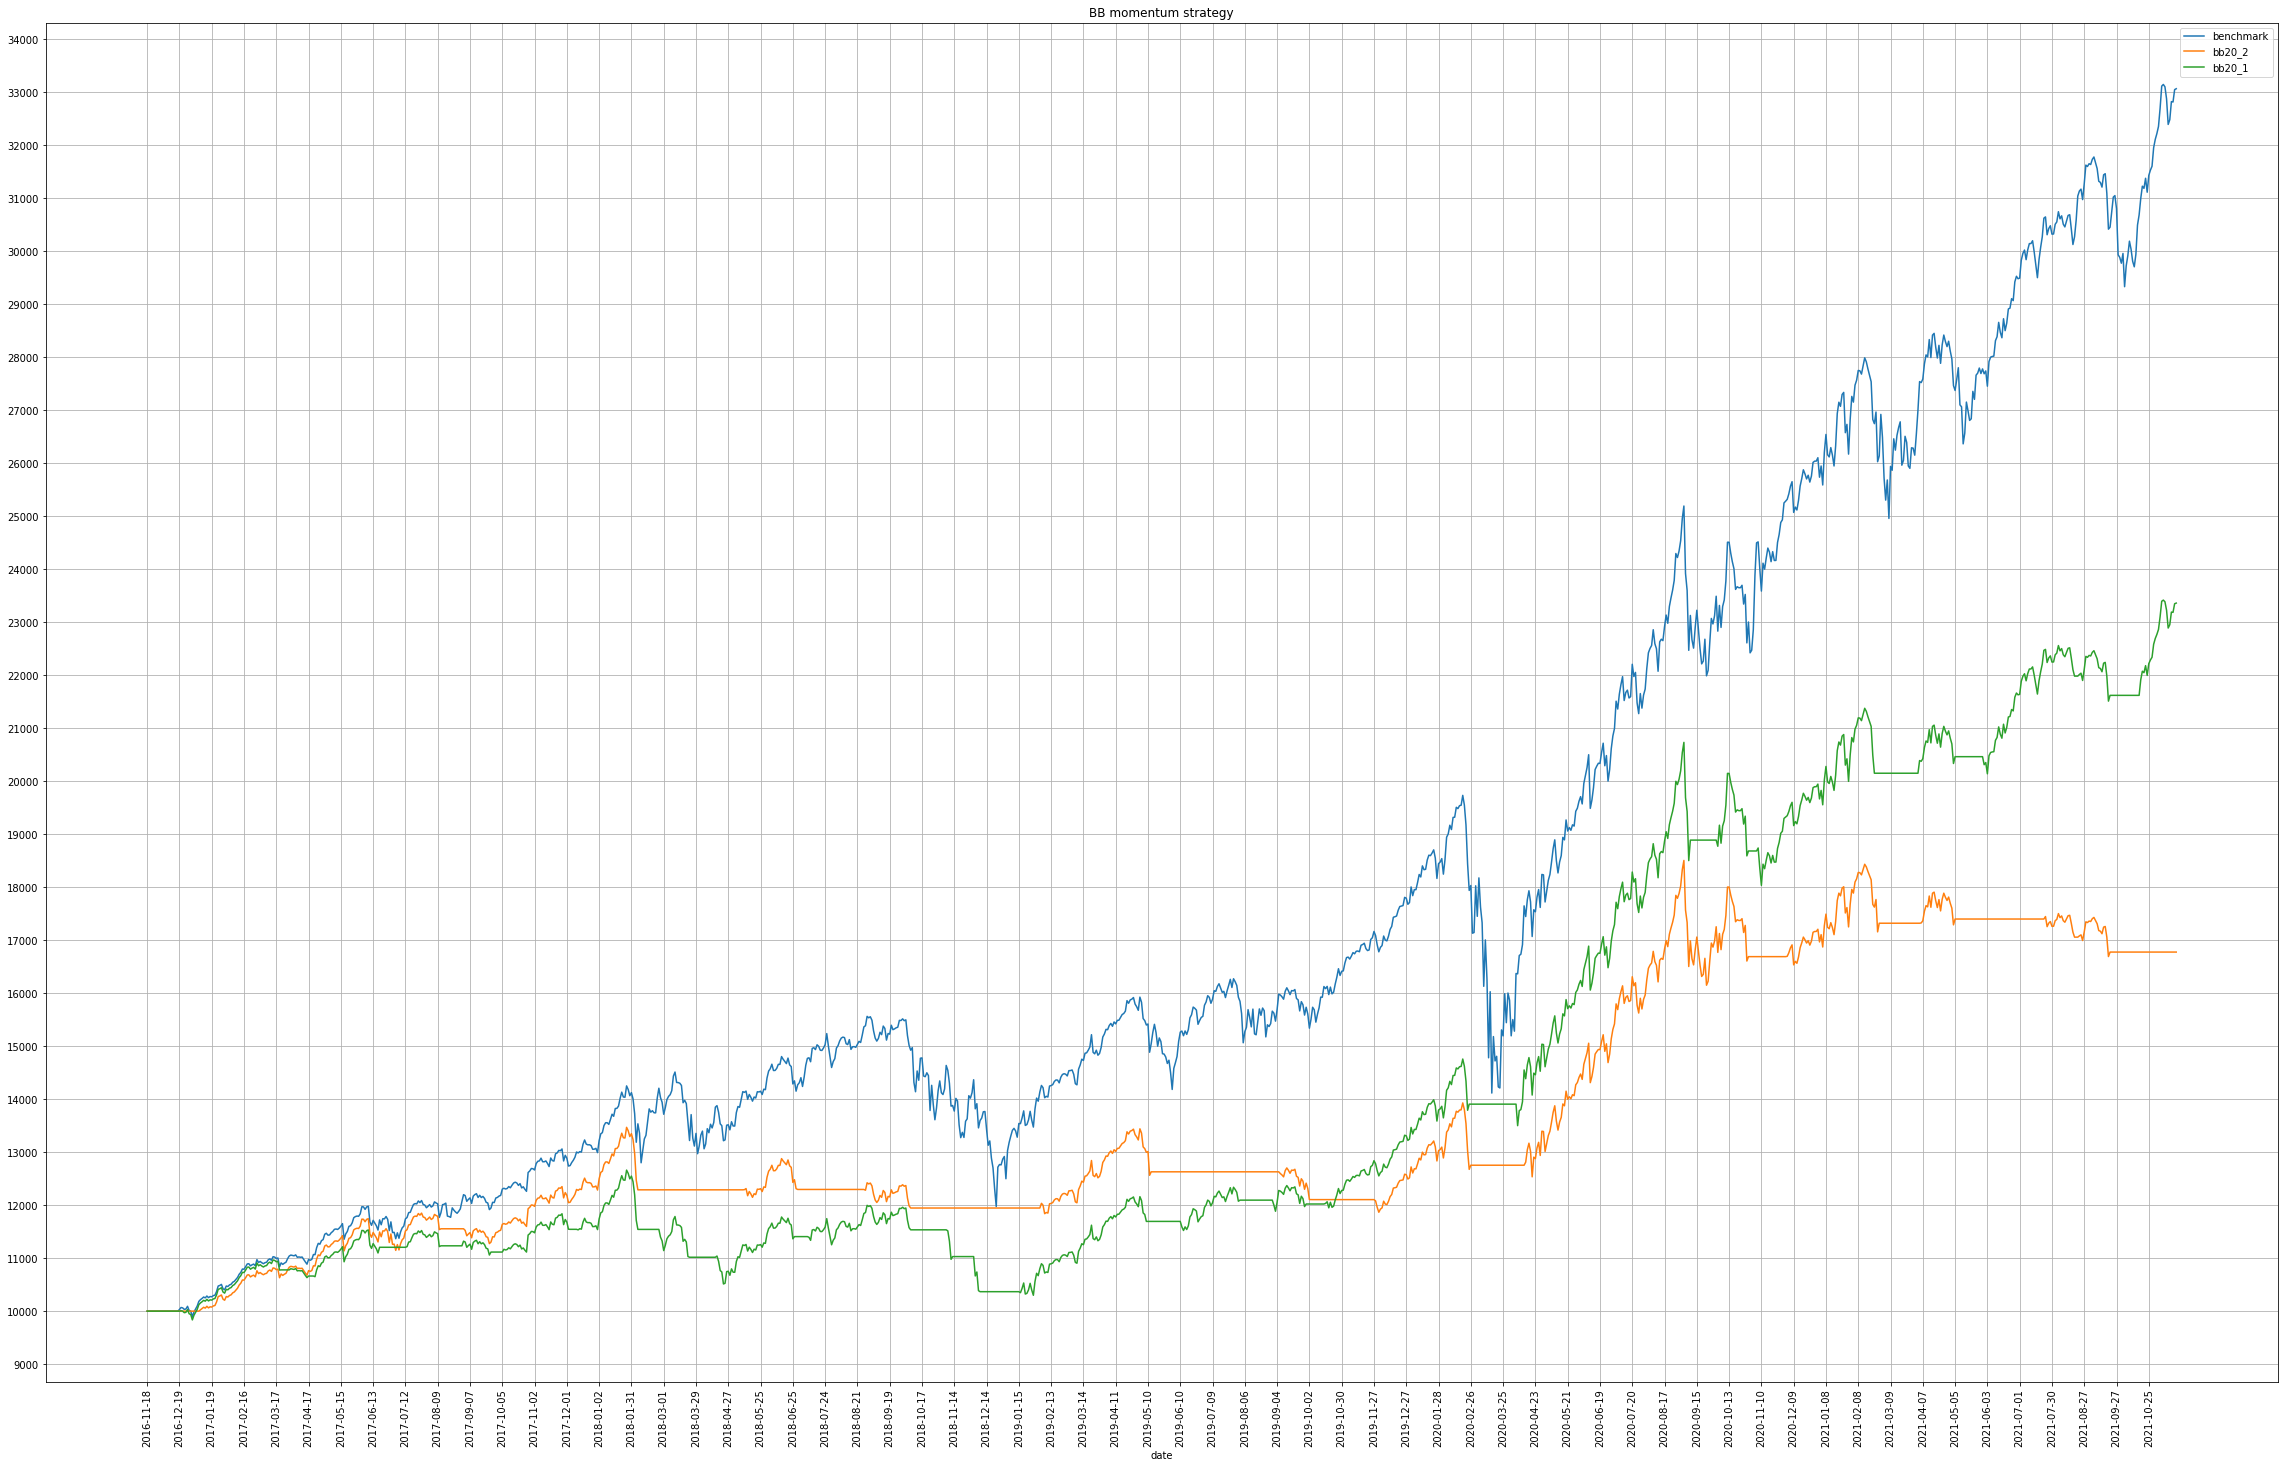

In [27]:
chart(returns_df)